<a href="https://colab.research.google.com/github/zzzeeshannn/Robotics/blob/main/ActorCritic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!pip install gym[atari]

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [2]:
!pip install pybullet

     |████████████████████████████████| 79.0MB 50kB/s 
  Created wheel for pybullet: filename=pybullet-3.1.7-cp37-cp37m-linux_x86_64.whl size=89750622 sha256=2c42efbefd82c2cf6dba185d5a235fa9f151a3d94e5ac7f9d7229f6a00b7ee94
  Stored in directory: /root/.cache/pip/wheels/30/56/e6/fce8276a2f30165f7ac31089bb72f390fa16b87328651e1a5a
Successfully built pybullet


In [3]:
!git clone https://github.com/benelot/pybullet-gym.git

Cloning into 'pybullet-gym'...
remote: Enumerating objects: 804, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 804 (delta 21), reused 18 (delta 5), pack-reused 750
Receiving objects: 100% (804/804), 19.31 MiB | 26.30 MiB/s, done.
Resolving deltas: 100% (437/437), done.


In [4]:
cd /content/pybullet-gym/

/content/pybullet-gym


In [5]:
!pip install -e .

Obtaining file:///content/pybullet-gym
  Running setup.py develop for pybulletgym


In [1]:
# Imports here
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import pybulletgym  # register PyBullet enviroments with open ai gym
import pybullet
import pybullet_data

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count
from collections import deque
import shutil

# Colab comes with PyTorch
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

from __future__ import division
from torch.autograd import Variable

import numpy as np
import math

from __future__ import division
import os
import psutil
import gc
from IPython.display import clear_output

In [2]:
# A plot function to continously print 
def subplot(R):
    r = R
    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
    ax.plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    plt.show()

In [3]:
# Defining the memory buffer here
class Memory: 
  def __init__(self, size): 
    self.buffer = deque(maxlen = size)        # Deque is a list-like collection which allows for fast-appends and pops on either side
    self.len = 0                              # Initialize this to 0, we keep increasing it as and when we add our experience to the Memory
    self.size = size                          # The maximum possible size of the Memory buffer
  
  def add(self, state, action, reward, next_state): 
    """
    This function is used to add the experience to the memory buffer
    We will be saving this as a tuple which makes it simpler to associate pairs while sampling
    """
    record = (state, action, reward, next_state)
    # Add the record to the memory
    self.len += 1
    if self.len > self.size:
      self.len = self.size
    self.buffer.append(record)
  
  def sample(self, sample_size): 
    """
    This function is used to sample experiences from the memory
    Input Parameter: sample_size decides the size of sample
    Returns: A batch of states, actions, rewards and next states in order
    """
    sampled_experience = []
    
    if sample_size < self.size: 
      sample_size = self.len
    
    sampled_experience = random.sample(self.buffer, sample_size)
    
    state_experience = []
    action_experience = []
    reward_experience = []
    next_state_experience = []

    # Important to convert it to ndarray 
    for every_experience in sampled_experience: 
      state_experience.append(np.float32(every_experience[0]))
      action_experience.append(np.float32(every_experience[1]))
      reward_experience.append(np.float32(every_experience[2]))
      next_state_experience.append(np.float32(every_experience[3]))
    
    return state_experience, action_experience, reward_experience, next_state_experience

In [4]:
EPS = 0.003

def fanin_init(size, fanin=None):
	fanin = fanin or size[0]
	v = 1. / np.sqrt(fanin)
	return torch.Tensor(size).uniform_(-v, v)

In [5]:
# Defining the Actor Network 
class Actor(nn.Module): 
  def __init__(self, state_dimensions, action_dimensions): 
    """
    Input Parameters: 
    Since the input to the network will be your state, the state dimensions are required
    Each node of the final layer of the network will correspond to one of the actions, hence the final 
    output layers should be the same as the number of actions
    """
    super(Actor, self).__init__()
    
    self.state_dim = state_dimensions
    self.action_dim = action_dimensions

    self.fc1 = nn.Linear(self.state_dim, 256)
    self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
    self.fc2 = nn.Linear(256,128)
    self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
    self.fc3 = nn.Linear(128, 64)
    self.fc3.weight.data = fanin_init(self.fc3.weight.data.size())
    self.fc4 = nn.Linear(64, self.action_dim)
    self.fc4.weight.data.uniform_(- EPS, EPS)
  
  def forward(self, state): 
    output = self.fc1(state)
    output = F.relu(output)
    output = self.fc2(output)
    output = F.relu(output)
    output = self.fc3(output)
    output = F.relu(output)
    action = self.fc4(output)

    return action

In [6]:
# Defining the Critic Network
class Critic(nn.Module): 
  def __init__(self, state_dimensions, action_dimensions):
    super(Critic, self).__init__()

    self.state_dim = state_dimensions
    self.action_dim = action_dimensions

    self.fcs1 = nn.Linear(self.state_dim, 256)
    self.fcs1.weight.data = fanin_init(self.fcs1.weight.data.size())
    self.fcs2 = nn.Linear(256, 128)
    self.fcs2.weight.data = fanin_init(self.fcs2.weight.data.size())

    self.fca1 = nn.Linear(self.action_dim, 256)
    self.fca1.weight.data = fanin_init(self.fca1.weight.data.size())
    self.fca2 = nn.Linear(256, 128)
    self.fca2.weight.data = fanin_init(self.fca2.weight.data.size())

    self.fc1 = nn.Linear(256, 128)
    self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
    self.fc2 = nn.Linear(128, 1)
    self.fc2.weight.data.uniform_(- EPS, EPS)
  
  def forward(self, state, action):
    state1 = self.fcs1(state)
    state1 = F.relu(state1)
    state2 = self.fcs2(state1)
    state2 = F.relu(state2)

    action1 = self.fca1(action)
    action1 = F.relu(action1)
    action2 = self.fca2(action1)
    action2 = F.relu(action2)

    temp = torch.cat((state2, action2), dim=1)

    output = self.fc1(temp)
    output = F.relu(output)
    output = self.fc2(output)

    return output

In [7]:
# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:

	def __init__(self, action_dim, mu = 0, theta = 0.15, sigma = 0.2):
		self.action_dim = action_dim
		self.mu = mu
		self.theta = theta
		self.sigma = sigma
		self.X = np.ones(self.action_dim) * self.mu

	def reset(self):
		self.X = np.ones(self.action_dim) * self.mu

	def sample(self):
		dx = self.theta * (self.mu - self.X)
		dx = dx + self.sigma * np.random.randn(len(self.X))
		self.X = self.X + dx
		return self.X

In [8]:
def soft_update(target, source, tau):
  for target_param, param in zip(target.parameters(), source.parameters()):
    target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

In [9]:
def hard_update(target, source):
  for target_param, param in zip(target.parameters(), source.parameters()):
    target_param.data.copy_(param.data)

In [10]:
# Defining a few parameters here
tau = 0.009
lr = 0.001
batch_size = 128
gamma = 0.99
MAX_EPISODES = 20000
MAX_STEPS = 1000
MAX_BUFFER = 1000000
MAX_TOTAL_REWARD = 300
PRINT_EVERY = 2
plot_reward = []

In [11]:
# We define our training module here
class Trainer: 
  def __init__(self, state_dimensions, action_dimensions, memory): 
    self.state_dim = state_dimensions
    self.action_dim = action_dimensions
    self.memory = memory
    self.iter_counter = 0
    self.noise = OrnsteinUhlenbeckActionNoise(self.action_dim)

    self.actor = Actor(self.state_dim, self.action_dim)
    self.target_actor = Actor(self.state_dim, self.action_dim)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr)

    self.critic = Critic(self.state_dim, self.action_dim)
    self.target_critic = Critic(self.state_dim, self.action_dim)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr)

    # Update here
    # You can either soft update or hard update between your target and current network
    # Hard update directly copies the parameters from source to target network 
    # Soft update: y = tau*x + (1-tau)*y

    hard_update(self.target_actor, self.actor)
    hard_update(self.target_critic, self.critic)
  
  def get_action_with_noise(self, state): 
    state = Variable(torch.from_numpy(state))
    action = self.target_actor.forward(state).detach()
    action_with_noise = action.data.numpy() 

    return action_with_noise
  
  def optimize(self): 
    """
    A function to optimize both actor-critic networks by sampling from experience buffer
    """

    state_experiences, action_experiences, rewards_experiences, next_state_batch = self.memory.sample(batch_size)
    
    # Converting it to a nd-array from list
    state_experiences = np.array(state_experiences)
    action_experiences = np.array(action_experiences)
    rewards_experiences = np.array(rewards_experiences)
    next_state_batch = np.array(next_state_batch)

    state_experiences = Variable(torch.from_numpy(state_experiences))
    action_experiences = Variable(torch.from_numpy(action_experiences))
    rewards_experiences = Variable(torch.from_numpy(rewards_experiences))
    next_state_batch = Variable(torch.from_numpy(next_state_batch))

    # Critic Network Optimization
    # Generating a new action for the next state sampled from the experience
    new_action = self.target_actor.forward(next_state_batch).detach()   
    # Generating the state-action value for this new state-action pair
    next_qvalue = torch.squeeze(self.target_critic.forward(next_state_batch, new_action).detach())    
    current_qval = torch.squeeze(self.target_critic.forward(state_experiences, action_experiences).detach())
    # Calculating the advantage 
    advantage = rewards_experiences + gamma*next_qvalue - current_qval
    # Prediciton 
    y_predicted = torch.squeeze(self.critic.forward(state_experiences, action_experiences))
    # Computing loss and updating the network
    critic_loss = F.smooth_l1_loss(y_predicted, advantage)
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()

    # Actor Network Optimization
    predicted_action = self.actor.forward(state_experiences)
    # Computing loss and updating the network
    actor_loss = -1 * torch.sum(self.critic.forward(state_experiences, predicted_action)*advantage)
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    # Update here 
    soft_update(self.target_actor, self.actor, tau)
    soft_update(self.target_critic, self.critic, tau)


In [12]:
# OpenAI Wrappers 
# You can directly import them as well
class NormalizedEnv(gym.ActionWrapper):
    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [13]:
# Another wrapper class
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

In [14]:
env = NormalizedEnv(gym.make("InvertedPendulumMuJoCoEnv-v0"))
env = ClipRewardEnv(env)

In [15]:
state_dimensions = env.observation_space.shape[0]
action_dimensions = env.action_space.shape[0]

print("State Space: ", state_dimensions)
print("Action Space: ", action_dimensions)

State Space:  4
Action Space:  1


In [16]:
# Initiate the memory buffer and trainer
memory = Memory(MAX_BUFFER)
train = Trainer(state_dimensions, action_dimensions, memory)

In [17]:
# Training procedure
for every_episode in range(MAX_EPISODES): 
  ep_reward = 0
  obs = env.reset()
  for t in range(100):
    state = np.float32(obs)
    action = train.get_action_with_noise(state)
    # Pass the action to the state
    new_state, reward, done, info = env.step(action)
    ep_reward += reward

    if done: 
      new_state = None
    else: 
      new_state = np.float32(new_state)
      # Save the experience in the memory buffer
      memory.add(state, action, reward, new_state)
    
    state = new_state
    train.optimize()
    
    # Break the loop if environment has terminated
    if done: 
      break
  print(" Episode number and Reward: ", every_episode, ep_reward)
  #plot_reward.append(ep_reward)
  #if (every_episode % PRINT_EVERY) == (PRINT_EVERY-1):
  #  plt.plot(plot_reward)
  #gc.collect()
plt.plot(ep_reward)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode number and Reward:  0 57.0
 Episode number and Reward:  1 13.0
 Episode number and Reward:  2 8.0
 Episode number and Reward:  3 8.0
 Episode number and Reward:  4 10.0
 Episode number and Reward:  5 7.0
 Episode number and Reward:  6 10.0
 Episode number and Reward:  7 11.0
 Episode number and Reward:  8 10.0
 Episode number and Reward:  9 8.0
 Episode number and Reward:  10 10.0
 Episode number and Reward:  11 7.0
 Episode number and Reward:  12 11.0
 Episode number and Reward:  13 11.0
 Episode number and Reward:  14 6.0
 Episode number and Reward:  15 7.0
 Episode number and Reward:  16 12.0
 Episode number and Reward:  17 11.0
 Episode number and Reward:  18 6.0
 Episode number and Reward:  19 9.0
 Episode number and Reward:  20 9.0
 Episode number and Reward:  21 8.0
 Episode number and Reward:  22 8.0
 Episode number and Reward:  23 12.0
 Episode number and Reward:  24 7.0
 Episode number and Reward:  25 10.0
 Episode number and Reward:  26 9.0
 Episode number and Rewar

KeyboardInterrupt: ignored

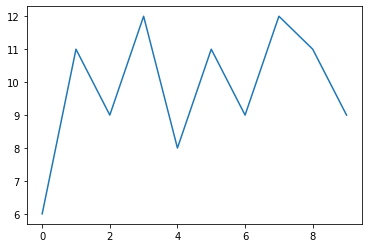

In [20]:
# Testing here 
total_rewards = []
for every_episode in range(10): 
  test_reward = 0
  obs = env.reset()
  for t in range(100):
    state = np.float32(obs)
    action = train.get_action_with_noise(state)
    # Pass the action to the state
    new_state, reward, done, info = env.step(action)
    test_reward += reward

    if done: 
      new_state = None
    else: 
      new_state = np.float32(new_state)
      # Save the experience in the memory buffer
      memory.add(state, action, reward, new_state)
    
    state = new_state
    
    # Break the loop if environment has terminated
    if done: 
      break
  total_rewards.append(test_reward)
plt.plot(total_rewards)